### 1. Preparación ambiente de trabajo

In [99]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import warnings

# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, classification_report

plt.style.use('seaborn') # gráficos estilo seaborn
plt.rcParams["figure.figsize"] = (8, 6) # Tamaño gráficos
plt.rcParams["figure.dpi"] = 70 # resolución gráficos
warnings.filterwarnings('ignore')

In [100]:
df = pd.read_csv('default_credit.csv').drop('index', axis=1)

In [101]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [102]:
df.shape

(10000, 4)

### 2. Análisis exploratorio

#### a) Boxplot balance total de las cuentas, segmentado por status de estudiante

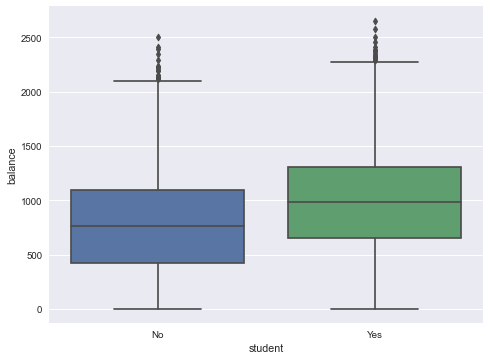

In [103]:
sns.boxplot(x=df['student'], y=df['balance'])

#### b) Boxplot ingreso total del cliente, segmentado por status del estudiante

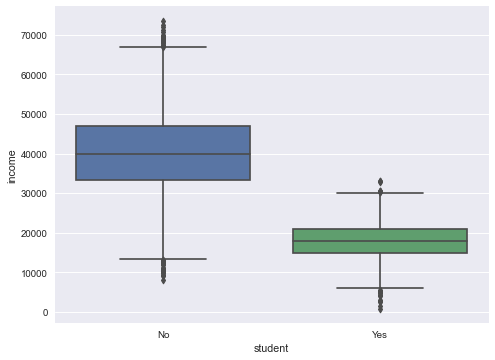

In [104]:
sns.boxplot(x=df['student'], y=df['income'])

#### c) Boxplot balance total cuentas, segmentado por status del default

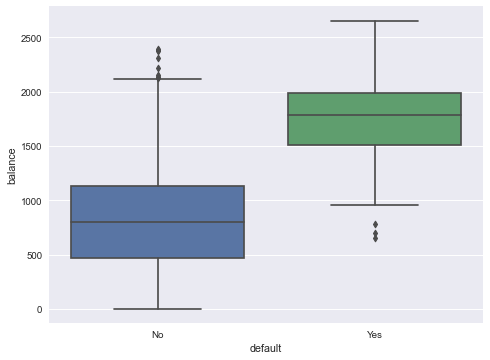

In [105]:
sns.boxplot(x=df['default'], y=df['balance'])

#### d) Boxplot ingreso total del cliente, segmentado por status del default

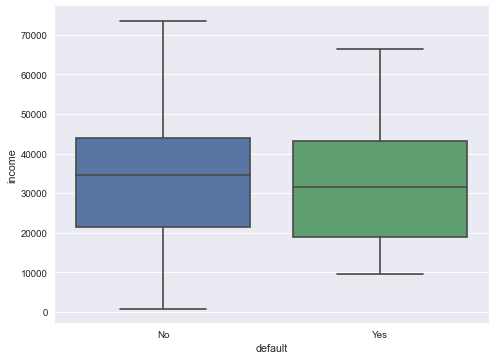

In [106]:
sns.boxplot(x=df['default'], y=df['income'])

#### e) Diagrama dispersión entre balance e income, segmentado por status del estudiante

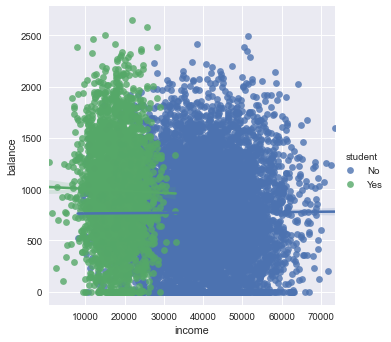

In [107]:
sns.lmplot(x='income', y='balance', hue='student', data=df)

#### f) Diagrama dispersión entre balance e income, segmentado por status de default

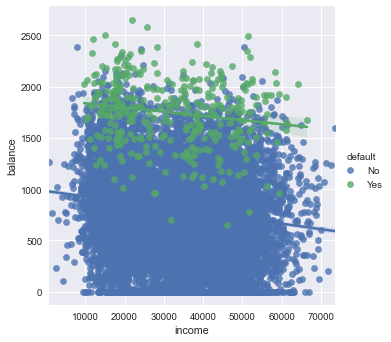

In [108]:
sns.lmplot(x='income', y='balance', hue='default', data=df)

#### Observaciones:

* (a, b) Los estudiantes poseen mayor balance en la cuenta de crédito, y tienen menor ingreso
* (c, d) Clientes morosos tienen mayor balance en la cuenta de crédito, y la mediana de su ingreso es menor en estado de morosidad
*  (e) Estudiantes tienen menor variabilidad de ingreso pero la dispersión del balance es similar a los no estudiantes
* (f) Clientes morosos tienen un balance mayor 

#### 3. Modelación econométrica

In [109]:
# recodificación variables categoricas
for col in ['student', 'default']:
    df[col] = df[col].replace(['No', 'Yes'], [0, 1])

In [110]:
modelo_1 = smf.logit('default ~ balance + income + student', data=df).fit()
modelo_1.summary()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 Jun 2022   Pseudo R-squ.:                  0.4619
Time:                        14:46:49   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance        0.0057      0.000     24.737      0.000       0.005       0.006
income      3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

A partir del resumen anterior identificamos que la variable income no es significativa ya que incluye al cero en su intervalo de confianza.

In [111]:
# dejamos solo variables significativas
modelo_2 = smf.logit('default ~ balance + student', data=df).fit()
modelo_2.summary()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Jun 2022   Pseudo R-squ.:                  0.4619
Time:                        14:46:49   Log-Likelihood:                -785.84
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                1.189e-293
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7495      0.369    -29.115      0.000     -11.473     -10.026
balance        0.0057      0.000     24.748      0.000       0.005       0.006
student       -0.7149      0.148     -4.846      0.000      -1.004      -0.426
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Observaciones:

* El modelo 2 mejora la interpretación de las variables significativas
* El balance afecta de forma positiva a la morosidad
* El echo de ser estudiante afecta negativamente sobre el estado de morosidad

### 4. Entrenar

In [112]:
# dataframe con variables significativas
df_significant = df.drop('income', axis=1)

In [113]:
# separando matriz de atributos de vector objetivo
mat_atr = df_significant.loc[:, ['student', 'balance']]
vec_obj = df_significant['default']

In [114]:
# split de conjuntos de entrenamiento vs prueba
X_train, X_test, y_train, y_test = train_test_split(mat_atr, vec_obj, test_size=.33, random_state=1238)

In [115]:
# estandarizamos conjunto de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)

In [116]:
# ajustamos modelo sin alterar hiperparámetros
modelo_3 =  LogisticRegression().fit(X_train_std, y_train)

In [117]:
# prediccion de clases y probabilidad
y_hat = modelo_3.predict(X_test)
prob_yhat = modelo_3.predict_proba(X_test)[:, 1]
y_hat, prob_yhat

(array([1, 1, 1, ..., 1, 1, 1]), array([1., 1., 1., ..., 1., 1., 1.]))

In [118]:
# metricas de precision, recall y f1 --> classification report
# el reporte no puede ser creado para las predicciones de probabilidad --> variables continuas

print(classification_report(y_test, y_hat))


              precision    recall  f1-score   support

           0       1.00      0.06      0.11      3194
           1       0.03      1.00      0.07       106

    accuracy                           0.09      3300
   macro avg       0.52      0.53      0.09      3300
weighted avg       0.97      0.09      0.11      3300



In [119]:
# curva roc
false_positive, true_positive, threshold = roc_curve(y_test, y_hat)

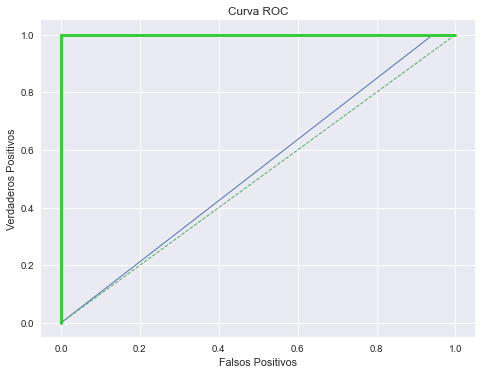

In [120]:
# grafico roc
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1], c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

### Observaciones:

* La curva ROC nos muestra que la capacidad predictiva del modelo es menor a la bisectriz. Es decir, por cada verdadero positivo, existe un mayor numero de falsos positivos.
* El f1 tanto para la clase 0 como 1 en la variable default es extremadamente bajo (<15%). Esto nos indica que la fraccion de etiquetas correctas es deficiente. 


De acuerdo a las observaciones anteriores podemos afirmar que la capacidad predictiva de nuestro modelo es deficiente.